# Simulating uniform randomness in boat placement

## Imports and SetUp

In [19]:
import random
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from tqdm import tqdm
import pandas as pd

In [5]:
N = 100000

## Creating boat placement functions

In [ ]:
def random_func1(weights=None):
    """Generate random coordinates, optionally using weights"""
    if weights is None:
        return random.randint(0,9), random.randint(0,9)
    else:
        # Flatten weights and create probability distribution
        flat_weights = weights.flatten()
        flat_weights = flat_weights / flat_weights.sum()  # Normalize
        
        # Choose a cell index based on weights
        cell_idx = np.random.choice(100, p=flat_weights)
        ligne = cell_idx // 10
        colonne = cell_idx % 10
        return ligne, colonne

### Version 1

#### Principe général

Cette première version implémente un __algorithme de placement aléatoire avec rejet__.
Pour chaque bateau, on génère des positions au hasard jusqu’à trouver une configuration valide.

#### Algorithme

1. Tirer aléatoirement une case de départ (ligne, colonne) et une orientation (horizontale ou verticale).

2. Vérifier que le bateau tient dans la grille selon cette orientation.

3. Générer la liste des cases occupées par le bateau.

4. Vérifier qu’aucune de ces cases n’est déjà occupée.

5. Si le placement est invalide (hors grille ou chevauchement), recommencer entièrement.

6. Sinon, valider le bateau et marquer ses cases comme occupées.

In [ ]:
# Place boats
def place_boats_v1(weights=None):
    """
    Generates random boat coordinates V1
    Returns
    ----------
        dict :
            A dictionnary with boat names as keys and lists of boat coordinates as tuples of two integers as items
    """
    bateaux = {"P":5,"C":4,"S":3,"T":2,"B":1}
    dict_bateau = {}
    case_occupe = []
    for symbole,taille in bateaux.items():
        invalid = False
        while invalid==False:
            ligne, colonne = random_func1(weights)
            orientation = random.choice(["H","V"])
            pos = []
            if orientation=="H":
                if colonne+taille<=10:
                    for i in range(taille):
                        p = (ligne,colonne+i)
                        pos.append(p)
                else:
                    pos = []
            else:
                if ligne+taille<=10:
                    for i in range(taille):
                        p = (ligne+i,colonne)
                        pos.append(p)
                else:
                    pos = []
            if pos!=[]:
                chevauchement = False
                for k in pos:
                    if k in case_occupe:
                        chevauchement=True
                if chevauchement==False:
                    dict_bateau[symbole] = pos
                    for x in pos:
                        case_occupe.append(x)
                    invalid=True
    return dict_bateau


### Version 2

#### Principe général

Cette version améliore la précédente en introduisant une logique adaptative :
au lieu d’abandonner immédiatement une position invalide, l’algorithme tente d’exploiter l’espace disponible autour du point de départ.

#### Algorithme

1. Tirer une case de départ et une orientation.

2. Tenter un placement classique dans cette direction.

3. En cas d’échec, tenter automatiquement l’orientation opposée.

4. Si le bateau ne tient toujours pas, appliquer un placement adaptatif :

    - Exploiter les cases disponibles d’un côté

    - Compléter de l’autre côté si nécessaire

5. Vérifier l’absence de chevauchement avant validation.

In [8]:

def place_boats_v2(weights=None):  
    """
    Generates random boat coordinates with adaptive placement
    
    Returns:
        dict:
            A dictionnary with boat names as keys and lists of boat coordinates as tuples of two integers as items
    """
    bateaux = {"P":5,"C":4,"S":3,"T":2,"B":1}
    dict_bateau = {}
    case_occupe = []
    
    for symbole, taille in bateaux.items():
        invalid = False
        while invalid == False:
            ligne, colonne = random_func1(weights)
            orientation = random.choice(["H","V"])
            
            # Tenter le placement dans la direction choisie
            pos = tenter_placement(ligne, colonne, taille, orientation)
            
            # Si échec, tenter l'autre direction
            if pos == []:
                orientation_alt = "V" if orientation == "H" else "H"
                pos = tenter_placement(ligne, colonne, taille, orientation_alt)
            
            # Si toujours échec, essayer placement adaptatif
            if pos == []:
                pos = placement_adaptatif(ligne, colonne, taille, orientation, case_occupe)
            
            if pos != []:
                chevauchement = False
                for k in pos:
                    if k in case_occupe:
                        chevauchement = True
                        break
                
                if chevauchement == False:
                    dict_bateau[symbole] = pos
                    case_occupe.extend(pos)
                    invalid = True
    
    return dict_bateau


def tenter_placement(ligne, colonne, taille, orientation):
    """Tente de placer un bateau dans une direction donnée"""
    pos = []
    
    if orientation == "H":
        if colonne + taille <= 10:
            pos = [(ligne, colonne + i) for i in range(taille)]
    else:
        if ligne + taille <= 10:
            pos = [(ligne + i, colonne) for i in range(taille)]
    
    return pos


def placement_adaptatif(ligne, colonne, taille, orientation, case_occupe):
    """
    Placement adaptatif: conserve les cases disponibles dans une direction
    et complète dans l'autre direction si nécessaire
    """
    pos = []
    
    if orientation == "H":
        # Compter cases disponibles à droite
        cases_droite = min(10 - colonne, taille)
        
        # Compter cases disponibles à gauche
        cases_gauche = min(colonne + 1, taille - cases_droite)
        
        if cases_droite + cases_gauche >= taille:
            # Placer à droite
            for i in range(cases_droite):
                pos.append((ligne, colonne + i))
            
            # Compléter à gauche si nécessaire
            manquant = taille - cases_droite
            for i in range(1, manquant + 1):
                pos.append((ligne, colonne - i))
    
    else:
        # Compter cases disponibles en bas
        cases_bas = min(10 - ligne, taille)
        
        # Compter cases disponibles en haut
        cases_haut = min(ligne + 1, taille - cases_bas)
        
        if cases_bas + cases_haut >= taille:
            # Placer en bas
            for i in range(cases_bas):
                pos.append((ligne + i, colonne))
            
            # Compléter en haut si nécessaire
            manquant = taille - cases_bas
            for i in range(1, manquant + 1):
                pos.append((ligne - i, colonne))
    
    return pos

### Version 3

#### Principe général

Cette version change complètement la logique de placement :
la case tirée au hasard devient le centre du bateau, et celui-ci s’étend symétriquement autour.

#### Algorithme

1. Tirer une case centrale et une orientation.

2. Déterminer la répartition gauche/droite (ou haut/bas) :

    - Taille impaire → centre exact

    - Taille paire → centre décalé

3. Vérifier que l’expansion est possible dans les deux directions.

4. Si nécessaire, ajuster le bateau pour rester dans la grille.

5. Valider le placement uniquement s’il n’y a aucun chevauchement.

In [9]:
def place_boats_v3(weights=None):  
    """
    Generates random boat coordinates with center-based expansion
    The generated coordinate becomes the center (or one of the centers) of the boat
    
    Returns:
        dict:
            A dictionnary with boat names as keys and lists of boat coordinates as tuples of two integers as items
    """
    bateaux = {"P":5,"C":4,"S":3,"T":2,"B":1}
    dict_bateau = {}
    case_occupe = []
    
    for symbole, taille in bateaux.items():
        invalid = False
        while invalid == False:
            ligne, colonne = random_func1(weights)
            orientation = random.choice(["H","V"])
            
            # Tenter expansion depuis le centre
            pos = expansion_depuis_centre(ligne, colonne, taille, orientation)
            
            # Si échec, tenter l'autre direction
            if pos == []:
                orientation_alt = "V" if orientation == "H" else "H"
                pos = expansion_depuis_centre(ligne, colonne, taille, orientation_alt)
            
            if pos != []:
                chevauchement = False
                for k in pos:
                    if k in case_occupe:
                        chevauchement = True
                        break
                
                if chevauchement == False:
                    dict_bateau[symbole] = pos
                    case_occupe.extend(pos)
                    invalid = True
    
    return dict_bateau


def expansion_depuis_centre(ligne, colonne, taille, orientation):
    """
    Expand bateau depuis le centre
    Pour taille impaire: le point devient le centre exact
    Pour taille paire: le point devient un des deux centres
    """
    pos = []
    
    if orientation == "H":
        # Calculer moitié gauche et droite
        if taille % 2 == 1:
            moitie = taille // 2
            gauche = moitie
            droite = moitie
        else:
            gauche = taille // 2 - 1
            droite = taille // 2
        
        # Vérifier si l'expansion est possible
        if colonne - gauche >= 0 and colonne + droite < 10:
            for i in range(-gauche, droite + 1):
                pos.append((ligne, colonne + i))
        else:
            # Tenter ajustement si dépasse les bords
            col_debut = max(0, colonne - gauche)
            col_fin = min(9, colonne + droite)
            
            if col_fin - col_debut + 1 == taille:
                for c in range(col_debut, col_fin + 1):
                    pos.append((ligne, c))
            elif colonne - gauche < 0:
                # Décalage vers la droite
                decalage = abs(colonne - gauche)
                for i in range(taille):
                    if colonne + i + decalage < 10:
                        pos.append((ligne, colonne + i + decalage))
                if len(pos) != taille:
                    pos = []
            else:
                # Décalage vers la gauche
                decalage = (colonne + droite) - 9
                for i in range(taille):
                    if colonne - i - decalage >= 0:
                        pos.insert(0, (ligne, colonne - i - decalage))
                if len(pos) != taille:
                    pos = []
    
    else:
        # Même logique pour vertical
        if taille % 2 == 1:
            moitie = taille // 2
            haut = moitie
            bas = moitie
        else:
            haut = taille // 2 - 1
            bas = taille // 2
        
        if ligne - haut >= 0 and ligne + bas < 10:
            for i in range(-haut, bas + 1):
                pos.append((ligne + i, colonne))
        else:
            ligne_debut = max(0, ligne - haut)
            ligne_fin = min(9, ligne + bas)
            
            if ligne_fin - ligne_debut + 1 == taille:
                for l in range(ligne_debut, ligne_fin + 1):
                    pos.append((l, colonne))
            elif ligne - haut < 0:
                decalage = abs(ligne - haut)
                for i in range(taille):
                    if ligne + i + decalage < 10:
                        pos.append((ligne + i + decalage, colonne))
                if len(pos) != taille:
                    pos = []
            else:
                decalage = (ligne + bas) - 9
                for i in range(taille):
                    if ligne - i - decalage >= 0:
                        pos.insert(0, (ligne - i - decalage, colonne))
                if len(pos) != taille:
                    pos = []
    
    return pos

### Version 4

#### Principe général

Cette version vise explicitement une répartition uniforme des bateaux sur la grille.
Elle introduit une stratégie inspirée des champs de potentiel ou de la répulsion.

#### Algorithme

1. Construire une carte de densité autour des cases déjà occupées.

2. Transformer cette densité en poids inverses :

    - Zones denses → faible probabilité

    - Zones vides → forte probabilité

3. Tirer une position aléatoire pondérée par ces poids.

4. Tenter un placement dans les deux orientations.

5. Répéter jusqu’à succès ou jusqu’à un nombre maximal de tentatives.

6. En dernier recours, effectuer un placement forcé exhaustif.

In [10]:
def place_boats_v4(weights=None):  
    """
    Generates boat coordinates with maximum uniform distribution
    Uses repulsion strategy to spread boats evenly across the grid
    
    Returns:
        dict:
            A dictionnary with boat names as keys and lists of boat coordinates as tuples of two integers as items
    """
    bateaux = {"P":5,"C":4,"S":3,"T":2,"B":1}
    dict_bateau = {}
    case_occupe = []
    
    for symbole, taille in bateaux.items():
        invalid = False
        tentatives = 0
        max_tentatives = 1000
        
        while invalid == False and tentatives < max_tentatives:
            tentatives += 1
            
            # Générer poids dynamiques basés sur la densité actuelle
            weights_dynamiques = calculer_poids_uniformite(case_occupe, weights)
            
            ligne, colonne = random_func1(weights_dynamiques)
            orientation = random.choice(["H","V"])
            
            pos = tenter_placement_uniform(ligne, colonne, taille, orientation)
            
            if pos == []:
                orientation_alt = "V" if orientation == "H" else "H"
                pos = tenter_placement_uniform(ligne, colonne, taille, orientation_alt)
            
            if pos != []:
                chevauchement = False
                for k in pos:
                    if k in case_occupe:
                        chevauchement = True
                        break
                
                if chevauchement == False:
                    dict_bateau[symbole] = pos
                    case_occupe.extend(pos)
                    invalid = True
        
        # Fallback si max_tentatives atteint
        if not invalid:
            pos = placement_force(taille, case_occupe)
            if pos:
                dict_bateau[symbole] = pos
                case_occupe.extend(pos)
    
    return dict_bateau


def calculer_poids_uniformite(case_occupe, weights_base=None):
    """
    Calcule des poids qui favorisent les zones peu occupées
    Crée une carte de densité et inverse les poids
    """
    grille_densite = np.zeros((10, 10))
    
    # Calculer densité autour de chaque case occupée
    for ligne, colonne in case_occupe:
        for dl in range(-2, 3):
            for dc in range(-2, 3):
                nl, nc = ligne + dl, colonne + dc
                if 0 <= nl < 10 and 0 <= nc < 10:
                    distance = max(abs(dl), abs(dc))
                    grille_densite[nl, nc] += 1.0 / (distance + 1)
    
    # Inverser les poids: zones denses = poids faibles
    poids = 1.0 / (grille_densite + 1.0)
    
    # Combiner avec weights_base si fourni
    if weights_base is not None:
        poids = poids * weights_base
    
    # Normaliser
    poids = poids / poids.sum()
    
    return poids


def tenter_placement_uniform(ligne, colonne, taille, orientation):
    """Tente placement standard"""
    pos = []
    
    if orientation == "H":
        if colonne + taille <= 10:
            pos = [(ligne, colonne + i) for i in range(taille)]
        elif colonne - taille + 1 >= 0:
            pos = [(ligne, colonne - i) for i in range(taille)]
    else:
        if ligne + taille <= 10:
            pos = [(ligne + i, colonne) for i in range(taille)]
        elif ligne - taille + 1 >= 0:
            pos = [(ligne - i, colonne) for i in range(taille)]
    
    return pos


def placement_force(taille, case_occupe):
    """
    Placement forcé en dernier recours
    Cherche systématiquement une position valide
    """
    for ligne in range(10):
        for colonne in range(10):
            for orientation in ["H", "V"]:
                pos = tenter_placement_uniform(ligne, colonne, taille, orientation)
                
                if pos:
                    valide = True
                    for k in pos:
                        if k in case_occupe:
                            valide = False
                            break
                    
                    if valide:
                        return pos
    
    return []

## Evaluating and comparing methods

In [ ]:
# 1. Simulate N times and count cell usage (uniform random)
def simulate_cell_usage(N, weights1=None, weights2=None, weights3=None, weights4=None):
    """Simulate boat placement N times and count cell usage"""
    grid_count1 = np.zeros((10, 10), dtype=int)
    grid_count2 = np.zeros((10, 10), dtype=int)
    grid_count3 = np.zeros((10, 10), dtype=int)
    grid_count4 = np.zeros((10, 10), dtype=int)
    
    for _ in tqdm(range(N)):
        boats1 = place_boats_v1(weights1)
        boats2 = place_boats_v2(weights2)
        boats3 = place_boats_v3(weights3)
        boats4 = place_boats_v4(weights4)
        for boat_coords in boats1.values():
            for ligne, colonne in boat_coords:
                grid_count1[ligne, colonne] += 1
        for boat_coords in boats2.values():
            for ligne, colonne in boat_coords:
                grid_count2[ligne, colonne] += 1
        for boat_coords in boats3.values():
            for ligne, colonne in boat_coords:
                grid_count3[ligne, colonne] += 1
        for boat_coords in boats4.values():
            for ligne, colonne in boat_coords:
                grid_count4[ligne, colonne] += 1
    
    return grid_count1, grid_count2, grid_count3, grid_count4

# 2. Compute weight map (inverse of usage frequency)
def compute_weight_map(grid_count):
    """
    Compute weights inversely proportional to usage frequency
    Less used cells get higher weights
    """
    # Avoid division by zero
    grid_count_safe = grid_count + 1
    
    # Inverse weights: cells used less get higher weights
    weights = 1.0 / grid_count_safe
    
    # Normalize weights
    weights = weights / weights.sum()
    
    return weights

# 3. Visualize results
def visualize_heatmap(grid, title, ax=None):
    """Visualize grid as heatmap"""
    if ax is None:
        fig, ax = plt.subplots(figsize=(8, 6))
    
    sns.heatmap(grid, annot=True, fmt='d', cmap='YlOrRd', 
                cbar_kws={'label': 'Count'}, ax=ax, square=True)
    ax.set_title(title)
    ax.set_xlabel('Column')
    ax.set_ylabel('Row')
    
    return ax

In [12]:
print(f"Running {N} simulations...")

# Step 1: Uniform random placement
print("\n1. Computing cell usage with uniform random placement...")
uniform_grid_v1, uniform_grid_v2, uniform_grid_v3, uniform_grid_v4 = simulate_cell_usage(N)

# Step 2: Compute weight map
print("2. Computing weight map...")
weight_map_v1 = compute_weight_map(uniform_grid_v1)
weight_map_v2 = compute_weight_map(uniform_grid_v2)
weight_map_v3 = compute_weight_map(uniform_grid_v3)
weight_map_v4 = compute_weight_map(uniform_grid_v4)

# Step 3: Weighted random placement
print("3. Computing cell usage with weigh_vted random placement...")
weighted_grid_v1, weighted_grid_v2, weighted_grid_v3, weighted_grid_v4 = simulate_cell_usage(N,
                                                                                            weights1=weight_map_v1,
                                                                                            weights2=weight_map_v2,
                                                                                            weights3=weight_map_v3,
                                                                                            weights4=weight_map_v4)

print ("Simulations Completed")

Running 100000 simulations...

1. Computing cell usage with uniform random placement...


  0%|          | 0/100000 [00:00<?, ?it/s]

100%|██████████| 100000/100000 [02:04<00:00, 806.33it/s]


2. Computing weight map...
3. Computing cell usage with weigh_vted random placement...


100%|██████████| 100000/100000 [02:27<00:00, 678.67it/s]


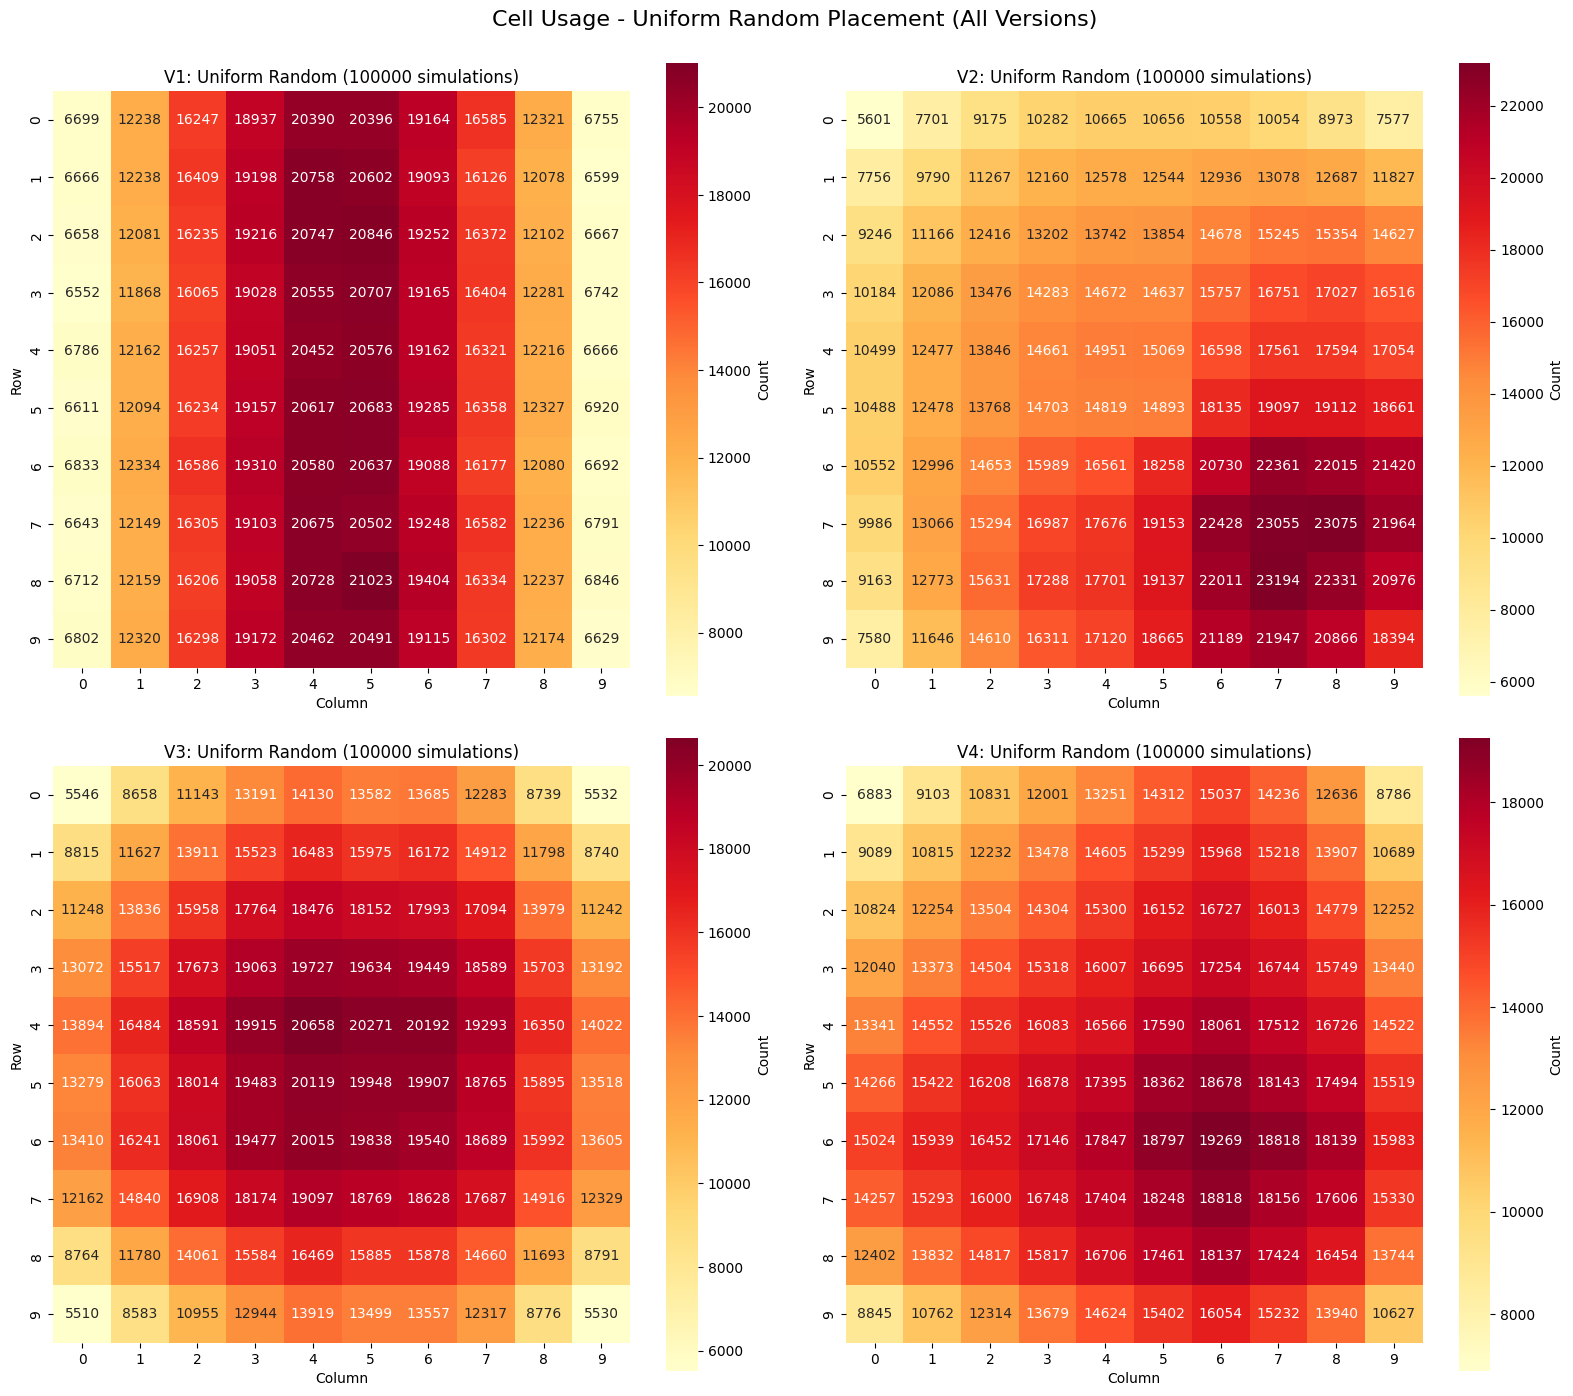

In [ ]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

visualize_heatmap(uniform_grid_v1, 
                  f'V1: Uniform Random ({N} simulations)', 
                  axes[0, 0])

visualize_heatmap(uniform_grid_v2, 
                  f'V2: Uniform Random ({N} simulations)', 
                  axes[0, 1])

visualize_heatmap(uniform_grid_v3, 
                  f'V3: Uniform Random ({N} simulations)', 
                  axes[1, 0])

visualize_heatmap(uniform_grid_v4, 
                  f'V4: Uniform Random ({N} simulations)', 
                  axes[1, 1])

plt.suptitle('Cell Usage - Uniform Random Placement (All Versions)', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

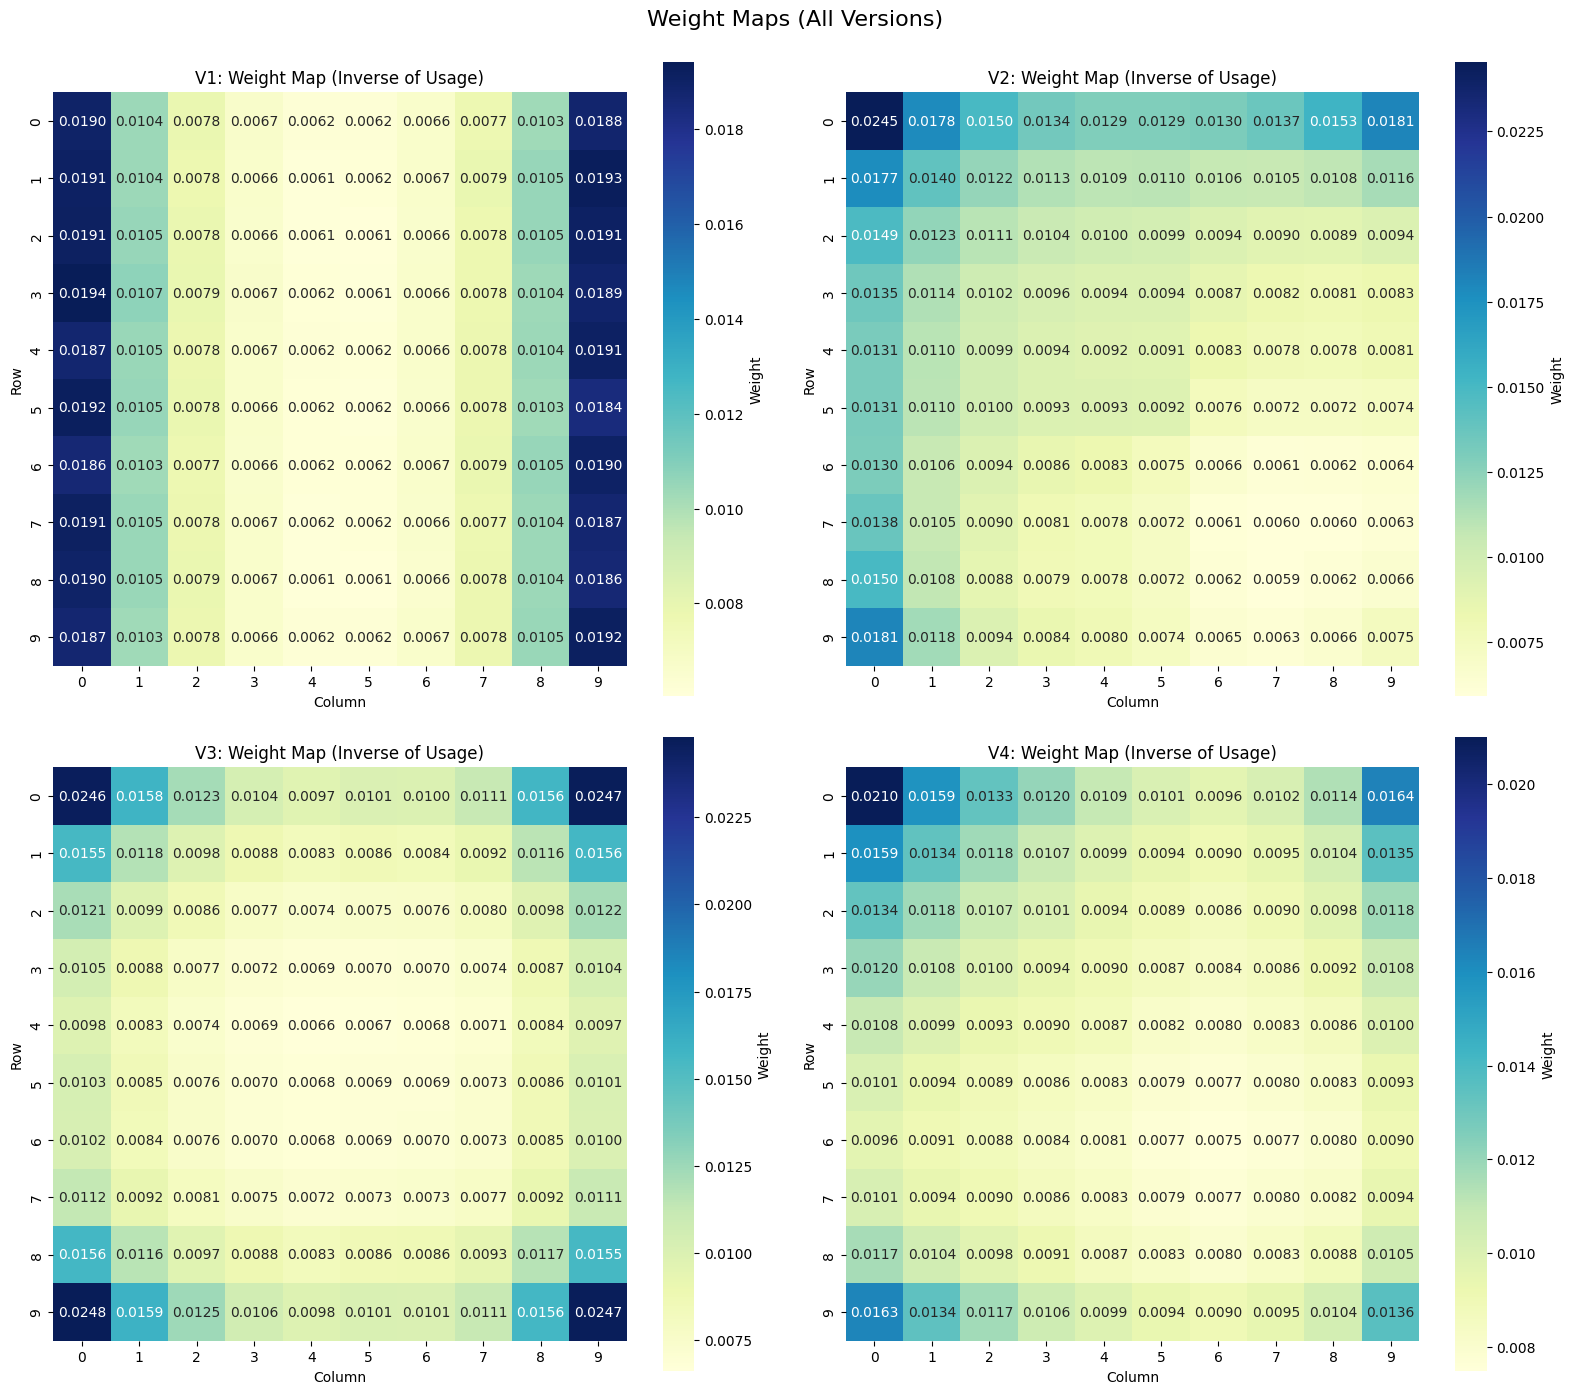

In [15]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

sns.heatmap(weight_map_v1, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'Weight'}, ax=axes[0, 0], square=True)
axes[0, 0].set_title('V1: Weight Map (Inverse of Usage)')
axes[0, 0].set_xlabel('Column')
axes[0, 0].set_ylabel('Row')

sns.heatmap(weight_map_v2, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'Weight'}, ax=axes[0, 1], square=True)
axes[0, 1].set_title('V2: Weight Map (Inverse of Usage)')
axes[0, 1].set_xlabel('Column')
axes[0, 1].set_ylabel('Row')

sns.heatmap(weight_map_v3, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'Weight'}, ax=axes[1, 0], square=True)
axes[1, 0].set_title('V3: Weight Map (Inverse of Usage)')
axes[1, 0].set_xlabel('Column')
axes[1, 0].set_ylabel('Row')

sns.heatmap(weight_map_v4, annot=True, fmt='.4f', cmap='YlGnBu', 
            cbar_kws={'label': 'Weight'}, ax=axes[1, 1], square=True)
axes[1, 1].set_title('V4: Weight Map (Inverse of Usage)')
axes[1, 1].set_xlabel('Column')
axes[1, 1].set_ylabel('Row')

plt.suptitle('Weight Maps (All Versions)', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

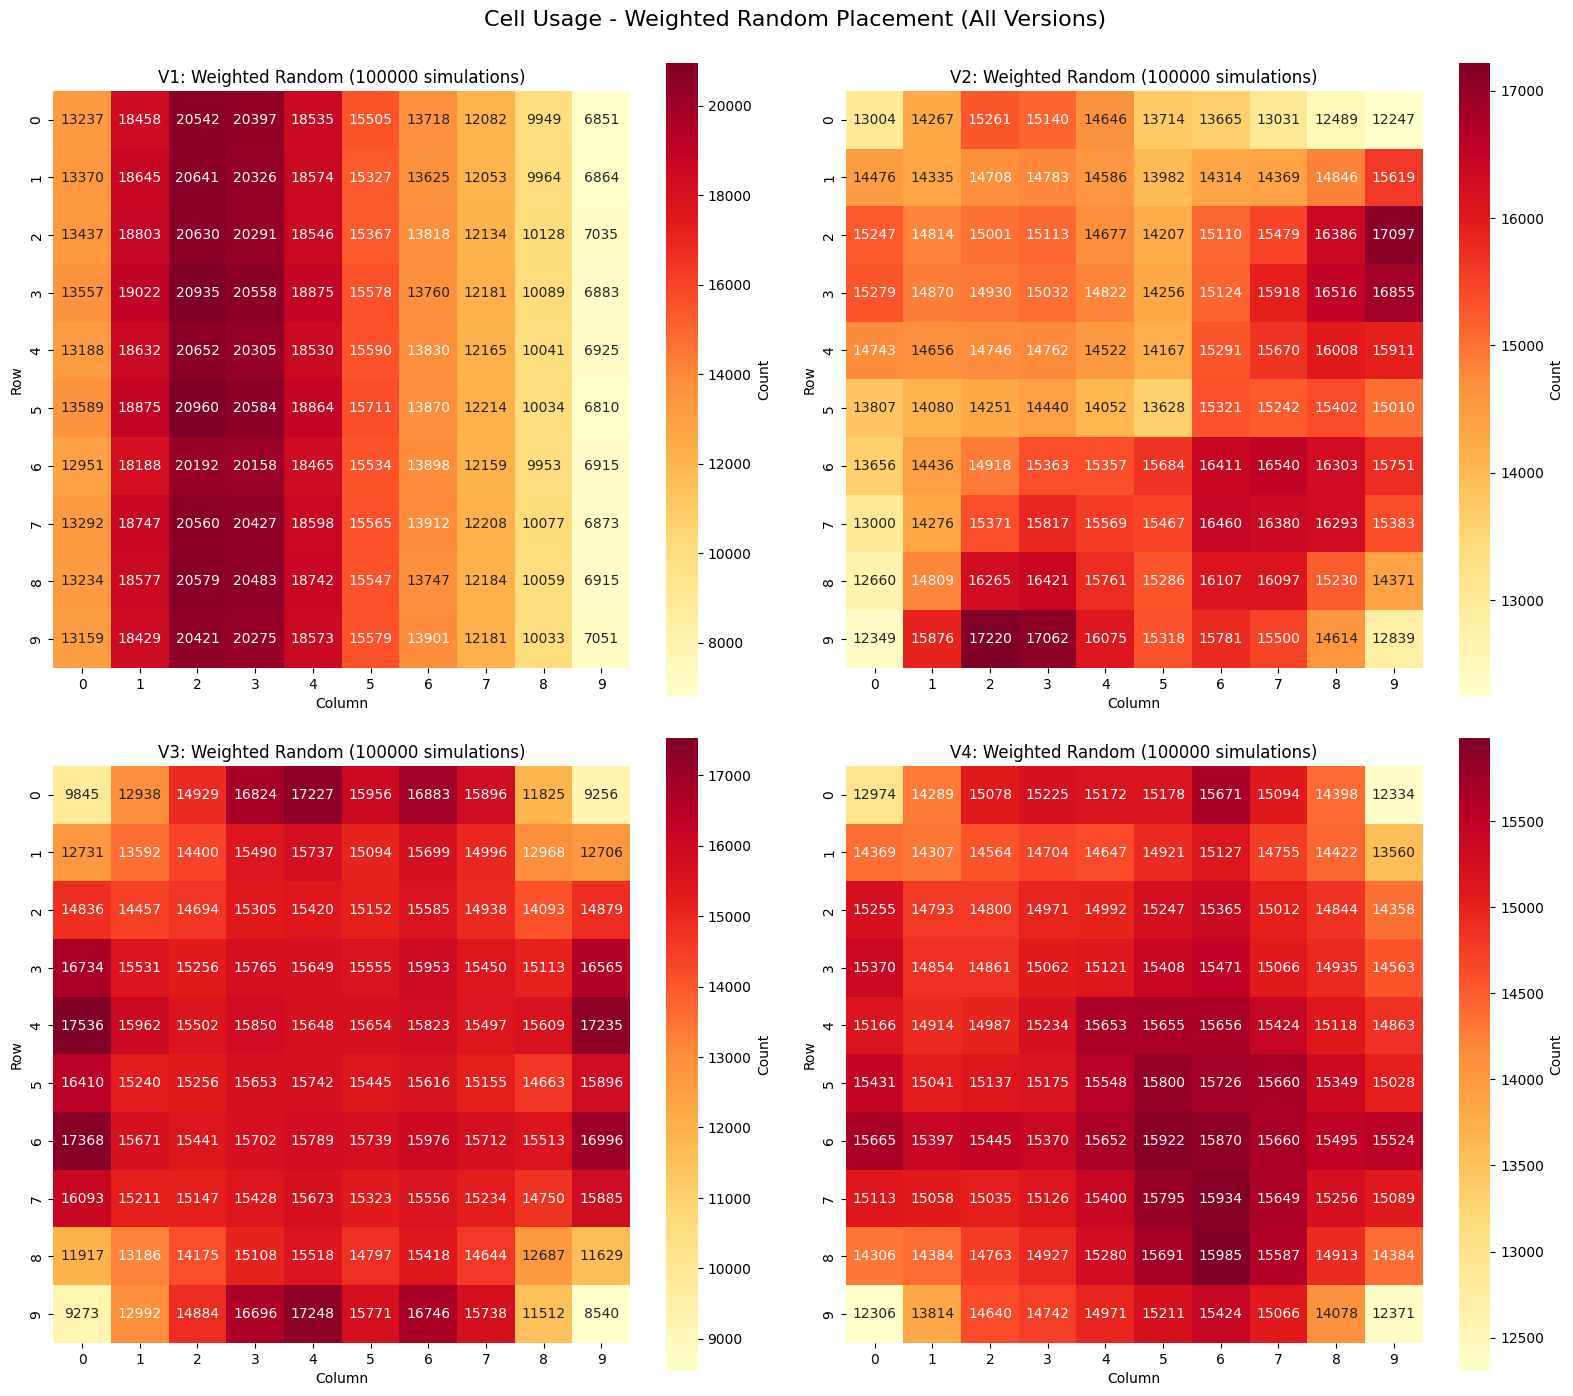

In [16]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

visualize_heatmap(weighted_grid_v1, 
                  f'V1: Weighted Random ({N} simulations)', 
                  axes[0, 0])

visualize_heatmap(weighted_grid_v2, 
                  f'V2: Weighted Random ({N} simulations)', 
                  axes[0, 1])

visualize_heatmap(weighted_grid_v3, 
                  f'V3: Weighted Random ({N} simulations)', 
                  axes[1, 0])

visualize_heatmap(weighted_grid_v4, 
                  f'V4: Weighted Random ({N} simulations)', 
                  axes[1, 1])

plt.suptitle('Cell Usage - Weighted Random Placement (All Versions)', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()

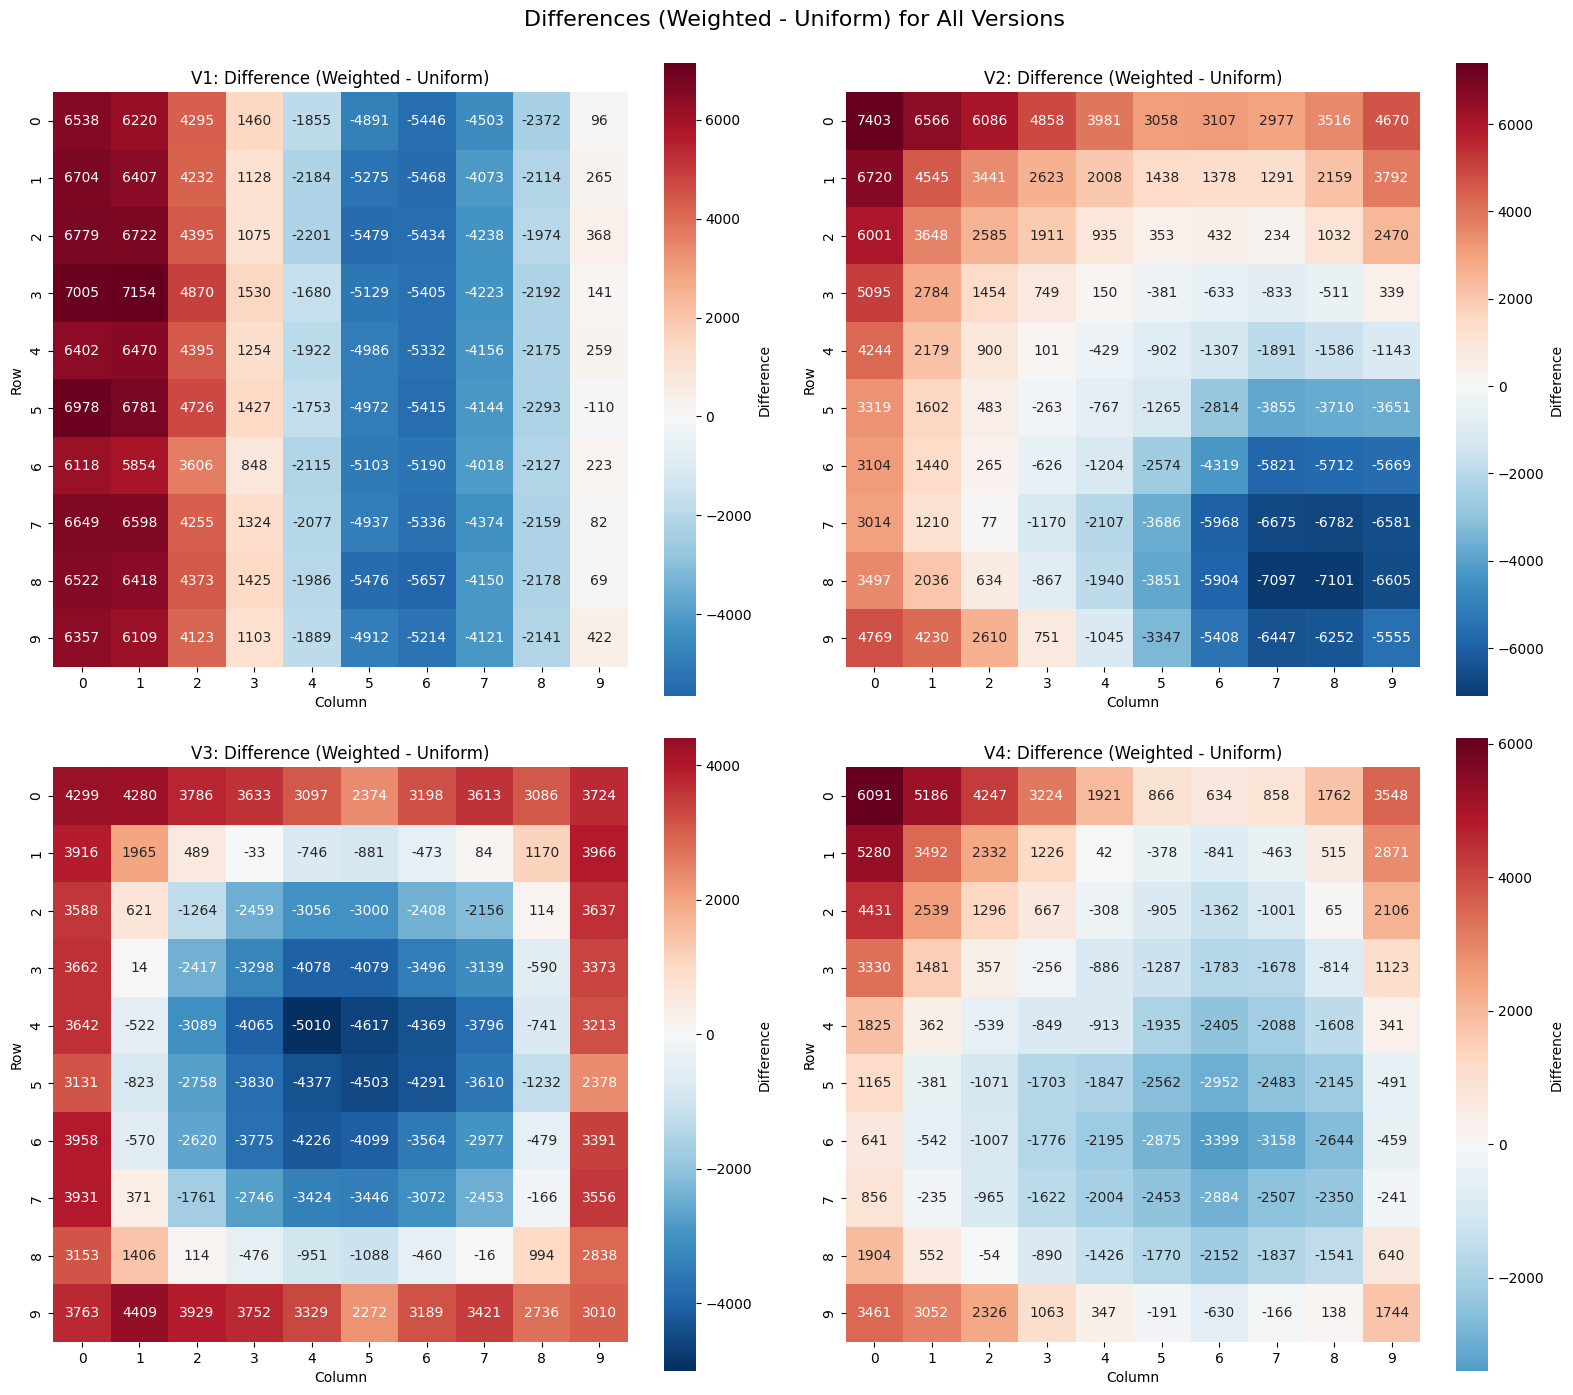

In [17]:
fig, axes = plt.subplots(2, 2, figsize=(16, 14))

difference_v1 = weighted_grid_v1 - uniform_grid_v1
sns.heatmap(difference_v1, annot=True, fmt='d', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Difference'}, ax=axes[0, 0], square=True)
axes[0, 0].set_title('V1: Difference (Weighted - Uniform)')
axes[0, 0].set_xlabel('Column')
axes[0, 0].set_ylabel('Row')

difference_v2 = weighted_grid_v2 - uniform_grid_v2
sns.heatmap(difference_v2, annot=True, fmt='d', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Difference'}, ax=axes[0, 1], square=True)
axes[0, 1].set_title('V2: Difference (Weighted - Uniform)')
axes[0, 1].set_xlabel('Column')
axes[0, 1].set_ylabel('Row')

difference_v3 = weighted_grid_v3 - uniform_grid_v3
sns.heatmap(difference_v3, annot=True, fmt='d', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Difference'}, ax=axes[1, 0], square=True)
axes[1, 0].set_title('V3: Difference (Weighted - Uniform)')
axes[1, 0].set_xlabel('Column')
axes[1, 0].set_ylabel('Row')

difference_v4 = weighted_grid_v4 - uniform_grid_v4
sns.heatmap(difference_v4, annot=True, fmt='d', cmap='RdBu_r', center=0,
            cbar_kws={'label': 'Difference'}, ax=axes[1, 1], square=True)
axes[1, 1].set_title('V4: Difference (Weighted - Uniform)')
axes[1, 1].set_xlabel('Column')
axes[1, 1].set_ylabel('Row')

plt.suptitle('Differences (Weighted - Uniform) for All Versions', fontsize=16, y=1.00)
plt.tight_layout()
plt.show()


In [23]:
def compute_stats(uniform_grid, weighted_grid, version_name):
    """Compute statistics for a version"""
    stats = {
        'Version': version_name,
        'Uniform Min': uniform_grid.min(),
        'Uniform Max': uniform_grid.max(),
        'Uniform Std': uniform_grid.std(),
        'Uniform Var': uniform_grid.var(),
        'Weighted Min': weighted_grid.min(),
        'Weighted Max': weighted_grid.max(),
        'Weighted Std': weighted_grid.std(),
        'Weighted Var': weighted_grid.var(),
    }
    stats['Var Reduction (%)'] = (1 - stats['Weighted Var'] / stats['Uniform Var']) * 100
    return stats

In [28]:
stats_list = [
    compute_stats(uniform_grid_v1, weighted_grid_v1, 'V1'),
    compute_stats(uniform_grid_v2, weighted_grid_v2, 'V2'),
    compute_stats(uniform_grid_v3, weighted_grid_v3, 'V3'),
    compute_stats(uniform_grid_v4, weighted_grid_v4, 'V4')
]

df_stats = pd.DataFrame(stats_list)

pd.options.display.float_format = '{:,.2f}'.format
df_stats

,Version,Uniform Min,Uniform Max,Uniform Std,Uniform Var,Weighted Min,Weighted Max,Weighted Std,Weighted Var,Var Reduction (%)
0,V1,6552,21023,"5,046.15","25,463,634.26",6810,20960,"4,356.64","18,980,304.12",25.46
1,V2,5601,23194,"4,179.91","17,471,627.24",12247,17220,"1,056.38","1,115,940.24",93.61
2,V3,5510,20658,"3,802.41","14,458,332.20",8540,17536,"1,692.12","2,863,279.34",80.20
3,V4,6883,19269,"2,571.54","6,612,801.08",12306,15985,692.74,"479,882.98",92.74


L’analyse des fréquences d’occupation des cases sur 100 000 simulations met en évidence des différences significatives entre les stratégies de placement étudiées.

Les versions V1 à V3 présentent une variabilité importante dans l’utilisation des cases, même lorsque des pondérations sont appliquées. Si les améliorations successives permettent de réduire progressivement cette variabilité, certaines zones de la grille restent structurellement plus sollicitées que d’autres.

La version V4 se distingue nettement par sa capacité à homogénéiser l’occupation de la grille. L’écart-type et la variance observés sont nettement inférieurs à ceux des autres versions, avec une réduction de la variance supérieure à 90 % avec l'ajout des poids sur la sélection des cases initiales. Cette diminution traduit une répartition beaucoup plus uniforme des bateaux, tout en conservant un caractère aléatoire dans les configurations générées.

Ces résultats montrent que les stratégies de placement fondées sur une régulation globale de l’espace, via des mécanismes de pondération dynamique, sont plus efficaces que les approches reposant uniquement sur des règles locales ou sur des ajustements géométriques. La version V4 apparaît ainsi comme la plus adaptée lorsque l’objectif est de minimiser les biais statistiques à long terme.